<center><img src="../images/DLI Header.png" alt="Header" style="width: 400px;"/></center>

# Getting Started with AI on Jetson Nano
### Interactive Regression Tool

This notebook is an interactive data collection, training, and testing tool, provided as part of the NVIDIA Deep Learning Institute (DLI) course, "Getting Started with AI on Jetson Nano". It is designed to be run on the Jetson Nano in conjunction with the detailed instructions provided in the online DLI course pages. 

To start the tool, set the **Camera** and **Task** code cell definitions, then execute all cells.  The interactive tool widgets at the bottom of the notebook will display.  The tool can then be used to gather data, add data, train data, and test data in an iterative and interactive fashion! 

The explanations in this notebook are intentionally minimal to provide a streamlined experience.  Please see the DLI course pages for detailed information on tool operation and project creation.

### Camera
First, create your camera and set it to `running`.  Uncomment the appropriate camera selection lines, depending on which type of camera you're using (USB or CSI). This cell may take several seconds to execute.
<div style="border:2px solid black; background-color:#e3ffb3; font-size:12px; padding:8px; margin-top: auto;">
    <h4><i>Tip</i></h4>
    <p>There can only be one instance of CSICamera or USBCamera at a time.  Before starting this notebook, make sure you have executed the final "shutdown" cell in any other notebooks you have run so that the camera is released. 
    </p>
</div>

In [1]:
# Check device number
!ls -ltrh /dev/video*

crw-rw---- 1 root video 81, 0 Dec 10 09:17 /dev/video0


In [4]:
from jetcam.usb_camera import USBCamera
from jetcam.csi_camera import CSICamera

# for USB Camera (Logitech C270 webcam), uncomment the following line
#camera = USBCamera(width=224, height=224, capture_device=0) # confirm the capture_device number

# for CSI Camera (Raspberry Pi Camera Module V2), uncomment the following line
camera = CSICamera(width=224, height=224, capture_device=0) # confirm the capture_device number

camera.running = True
print("camera created")

camera created


### Task
Next, define your project `TASK` and what `CATEGORIES` of data you will collect.  You may optionally define space for multiple `DATASETS` with names of your choosing. 

 Uncomment/edit the associated lines for the XY regression task you're building and execute the cell. This cell should only take a few seconds to execute.

In [5]:
import torchvision.transforms as transforms
from dataset import XYDataset

TASK = 'face'
# TASK = 'diy'

CATEGORIES = ['nose', 'left_eye', 'right_eye']
# CATEGORIES = [ 'diy_1', 'diy_2', 'diy_3']

DATASETS = ['A', 'B']
# DATASETS = ['A', 'B', 'C']

TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

datasets = {}
for name in DATASETS:
    datasets[name] = XYDataset('../data/regression/' + TASK + '_' + name, CATEGORIES, TRANSFORMS)
    
print("{} task with {} categories defined".format(TASK, CATEGORIES))

face task with ['nose', 'left_eye', 'right_eye'] categories defined


In [6]:
# Set up the data directory location if not there already
DATA_DIR = '/nvdli-nano/data/regression/'
!mkdir -p {DATA_DIR}

### Data Collection
Execute the cell below to create the data collection tool widget. This cell should only take a few seconds to execute.

In [7]:
import cv2
import ipywidgets
import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg
from jupyter_clickable_image_widget import ClickableImageWidget


# initialize active dataset
dataset = datasets[DATASETS[0]]

# unobserve all callbacks from camera in case we are running this cell for second time
camera.unobserve_all()

# create image preview
camera_widget = ClickableImageWidget(width=camera.width, height=camera.height)
with open("../images/ready_img.jpg", "rb") as file:
    default_image = file.read()
snapshot_widget = ipywidgets.Image(value=default_image, width=camera.width, height=camera.height)
traitlets.dlink((camera, 'value'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# create widgets
dataset_widget = ipywidgets.Dropdown(options=DATASETS, description='dataset')
category_widget = ipywidgets.Dropdown(options=dataset.categories, description='category')
count_widget = ipywidgets.IntText(description='count')

# manually update counts at initialization
count_widget.value = dataset.get_count(category_widget.value)

# sets the active dataset
def set_dataset(change):
    global dataset
    dataset = datasets[change['new']]
    count_widget.value = dataset.get_count(category_widget.value)
dataset_widget.observe(set_dataset, names='value')

# update counts when we select a new category
def update_counts(change):
    count_widget.value = dataset.get_count(change['new'])
category_widget.observe(update_counts, names='value')


def save_snapshot(_, content, msg):
    if content['event'] == 'click':
        data = content['eventData']
        x = data['offsetX']
        y = data['offsetY']
        
        # save to disk
        dataset.save_entry(category_widget.value, camera.value, x, y)
        
        # display saved snapshot
        snapshot = camera.value.copy()
        snapshot = cv2.circle(snapshot, (x, y), 8, (0, 255, 0), 3)
        snapshot_widget.value = bgr8_to_jpeg(snapshot)
        count_widget.value = dataset.get_count(category_widget.value)
        
camera_widget.on_msg(save_snapshot)

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget, snapshot_widget]),
    dataset_widget,
    category_widget,
    count_widget
])

# display(data_collection_widget)
print("data_collection_widget created")

data_collection_widget created


### Model
Execute the following cell to define the neural network and adjust the fully connected layer (`fc`) to match the outputs required for the project.  This cell may take several seconds to execute.

In [8]:
import torch
import torchvision

device = torch.device('cuda')
output_dim = 2 * len(dataset.categories)  # x, y coordinate for each category

# ALEXNET
# model = torchvision.models.alexnet(pretrained=True)
# model.classifier[-1] = torch.nn.Linear(4096, output_dim)

# SQUEEZENET 
# model = torchvision.models.squeezenet1_1(pretrained=True)
# model.classifier[1] = torch.nn.Conv2d(512, output_dim, kernel_size=1)
# model.num_classes = len(dataset.categories)

# RESNET 18
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)

# RESNET 34
# model = torchvision.models.resnet34(pretrained=True)
# model.fc = torch.nn.Linear(512, output_dim)

model = model.to(device)

model_save_button = ipywidgets.Button(description='save model')
model_load_button = ipywidgets.Button(description='load model')
model_path_widget = ipywidgets.Text(description='model path', value='/nvdli-nano/data/regression/my_xy_model.pth')

def load_model(c):
    model.load_state_dict(torch.load(model_path_widget.value))
model_load_button.on_click(load_model)
    
def save_model(c):
    torch.save(model.state_dict(), model_path_widget.value)
model_save_button.on_click(save_model)

model_save_button.click()

model_widget = ipywidgets.VBox([
    model_path_widget,
    ipywidgets.HBox([model_load_button, model_save_button])
])

# display(model_widget)
print("model configured and model_widget created")

model configured and model_widget created


### Live  Execution
Execute the cell below to set up the live execution widget.  This cell should only take a few seconds to execute.

In [9]:
import threading
import time
from utils import preprocess
import torch.nn.functional as F

state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
with open("../images/ready_img.jpg", "rb") as file:
    default_image = file.read()
prediction_widget = ipywidgets.Image(format='jpeg', width=camera.width, height=camera.height, value=default_image)

def live(state_widget, model, camera, prediction_widget):
    global dataset
    while state_widget.value == 'live':
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed).detach().cpu().numpy().flatten()
        category_index = dataset.categories.index(category_widget.value)
        x = output[2 * category_index]
        y = output[2 * category_index + 1]
        
        x = int(camera.width * (x / 2.0 + 0.5))
        y = int(camera.height * (y / 2.0 + 0.5))
        
        prediction = image.copy()
        prediction = cv2.circle(prediction, (x, y), 8, (255, 0, 0), 3)
        prediction_widget.value = bgr8_to_jpeg(prediction)
            
def start_live(change):
    if change['new'] == 'live':
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget))
        execute_thread.start()

state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    prediction_widget,
    state_widget
])

# display(live_execution_widget)
print("live_execution_widget created")

live_execution_widget created


### Training and Evaluation
Execute the following cell to define the trainer, and the widget to control it. This cell may take several seconds to execute.

In [10]:
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

epochs_widget = ipywidgets.IntText(description='epochs', value=1)
eval_button = ipywidgets.Button(description='evaluate')
train_button = ipywidgets.Button(description='train')
loss_widget = ipywidgets.FloatText(description='loss')
progress_widget = ipywidgets.FloatProgress(min=0.0, max=1.0, description='progress')

def train_eval(is_training):
    global BATCH_SIZE, LEARNING_RATE, MOMENTUM, model, dataset, optimizer, eval_button, train_button, accuracy_widget, loss_widget, progress_widget, state_widget
    
    try:
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        state_widget.value = 'stop'
        train_button.disabled = True
        eval_button.disabled = True
        time.sleep(1)

        if is_training:
            model = model.train()
        else:
            model = model.eval()

        while epochs_widget.value > 0:
            i = 0
            sum_loss = 0.0
            error_count = 0.0
            for images, category_idx, xy in iter(train_loader):
                # send data to device
                images = images.to(device)
                xy = xy.to(device)

                if is_training:
                    # zero gradients of parameters
                    optimizer.zero_grad()

                # execute model to get outputs
                outputs = model(images)

                # compute MSE loss over x, y coordinates for associated categories
                loss = 0.0
                for batch_idx, cat_idx in enumerate(list(category_idx.flatten())):
                    loss += torch.mean((outputs[batch_idx][2 * cat_idx:2 * cat_idx+2] - xy[batch_idx])**2)
                loss /= len(category_idx)

                if is_training:
                    # run backpropogation to accumulate gradients
                    loss.backward()

                    # step optimizer to adjust parameters
                    optimizer.step()

                # increment progress
                count = len(category_idx.flatten())
                i += count
                sum_loss += float(loss)
                progress_widget.value = i / len(dataset)
                loss_widget.value = sum_loss / i
                
            if is_training:
                epochs_widget.value = epochs_widget.value - 1
            else:
                break
    except e:
        pass
    model = model.eval()

    train_button.disabled = False
    eval_button.disabled = False
    state_widget.value = 'live'
    
train_button.on_click(lambda c: train_eval(is_training=True))
eval_button.on_click(lambda c: train_eval(is_training=False))
    
train_eval_widget = ipywidgets.VBox([
    epochs_widget,
    progress_widget,
    loss_widget,
    ipywidgets.HBox([train_button, eval_button])
])

# display(train_eval_widget)
print("trainer configured and train_eval_widget created")

trainer configured and train_eval_widget created


### Display the Interactive Tool!

The interactive tool includes widgets for data collection, training, and testing.  

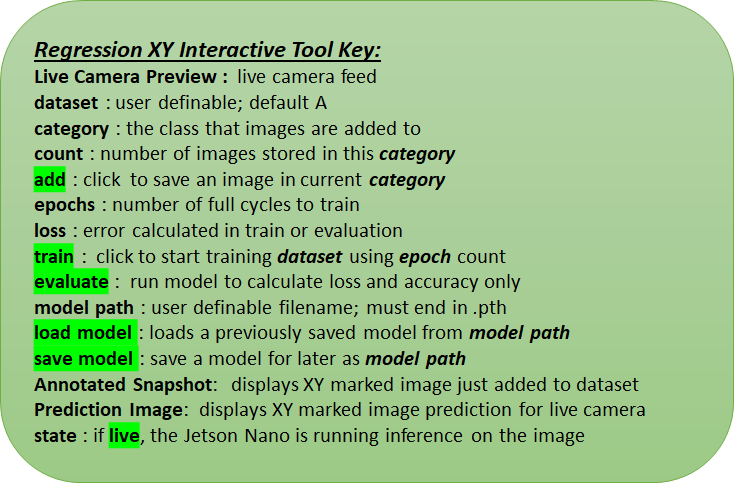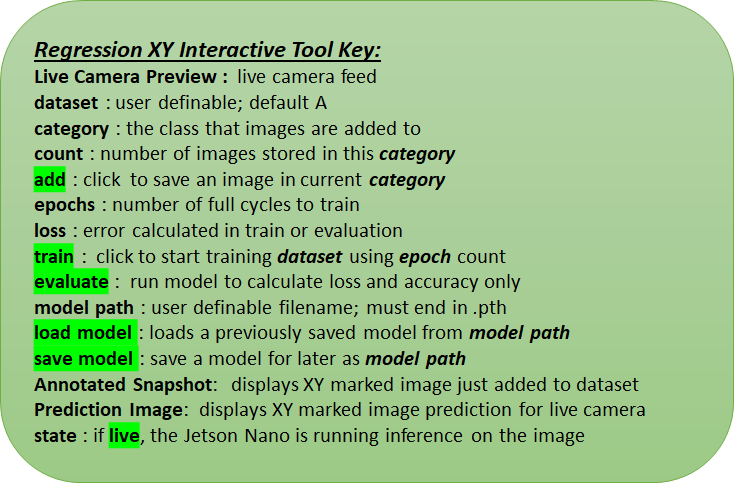<center><img src="../images/regression_XY_tool_key2.png" alt="tool key" width=500/></center>
<br>
<center><img src="../images/regression_XY_tool_key1.png" alt="tool key"/></center>

Execute the cell below to create and display the full interactive widget.  Follow the instructions in the online DLI course pages to build your project.

In [11]:
# Combine all the widgets into one display
all_widget = ipywidgets.VBox([
    ipywidgets.HBox([data_collection_widget, live_execution_widget]), 
    train_eval_widget,
    model_widget
])

display(all_widget)

<h1 style="background-color:#76b900;"></h1>

## Before you go...<br><br>Shut down the camera and/or notebook kernel to release the camera resource

In [ ]:
# Attention!  Execute this cell before moving to another notebook
# The USB camera application only requires that the notebook be reset
# The CSI camera application requires that the 'camera' object be specifically released

import os
import IPython

if type(camera) is CSICamera:
    print("Ignore 'Exception in thread' tracebacks\n")
    camera.cap.release()

os._exit(00)

Return to the DLI course pages for the next instructions.

<center><img src="../images/DLI Header.png" alt="Header" style="width: 400px;"/></center>